In [1]:
#%load_ext tensorboard

In [2]:
import numpy as np
import pandas as pd
import io
import re
import tensorflow as tf
import keras
from keras import layers
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import activations
import datetime
import tensorboard
from plotnine import *
import os

In [3]:
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [4]:
units = 256
epochs = 100
class_ratio = {0:1.0, 1:4.0}
prediction_horizon = 10
sampling_rate = 1
stride = 1
batch_size = 756
input_shape = (prediction_horizon, 652)
threshold = 60

In [5]:
precipitation_NL = pd.read_csv("C:\\Users\\wolff\\Desktop\\AI for Climate\\Datasets\\PrecipitationNL.csv")
daily_mean_sea_level_pressure_NL = pd.read_csv("C:\\Users\\wolff\\OneDrive\\Uni\\Fünftes Semester\\Hackathon\\DailyMeanSeaLevelPressureNL.csv")
mean_temperature_NL = pd.read_csv("C:\\Users\\wolff\\OneDrive\\Uni\\Fünftes Semester\\Hackathon\\MeanTemperatureNL.csv")
wind_directoin_NL = pd.read_csv("C:\\Users\\wolff\\OneDrive\\Uni\\Fünftes Semester\\Hackathon\\WindDirectionNL.csv")
wind_speed_NL =  pd.read_csv("C:\\Users\\wolff\\OneDrive\\Uni\\Fünftes Semester\\Hackathon\\WindSpeedNL.csv")
humidity_neighbors = pd.read_csv("C:\\Users\\wolff\\OneDrive\\Uni\\Fünftes Semester\\Hackathon\\HumidityFR_DE_BE.csv")
pressure_neighbors = pd.read_csv("C:\\Users\\wolff\\OneDrive\\Uni\\Fünftes Semester\\Hackathon\\DailyMeanSeaLevelPressureFR_DE_BE.csv")

In [6]:
"""
precipitation_NL = pd.read_csv('PrecipitationNL.csv')
daily_mean_sea_level_pressure_NL = pd.read_csv('DailyMeanSeaLevelPressureNL.csv')
mean_temperature_NL = pd.read_csv('MeanTemperatureNL.csv')
wind_directoin_NL = pd.read_csv('WindDirectionNL.csv')
wind_speed_NL = pd.read_csv('WindSpeedNL.csv')
"""

def prepare_CSV(data_frame, start_date, description):
  # changes first column to date column
  data_frame.iloc[:,0] = pd.date_range(start=start_date, periods=len(data_frame), freq='D')
  # names all columns in the style 'Prec_MeasureID'
  data_frame = data_frame.rename(columns= lambda col: description + '_' + str(re.findall(r"\d+",col)[0]))
  # names first columns to 'Date'
  data_frame = data_frame.rename(columns={description + '_0':'Date'})
  # cast all -9999 values to NaN
  data_frame = data_frame.replace(-9999, 0)

  return data_frame


precipitation_NL = prepare_CSV(precipitation_NL, '1/1/1980', 'Prec')
daily_mean_sea_level_pressure_NL = prepare_CSV(daily_mean_sea_level_pressure_NL, '1/1/1980', 'DMSLP')
mean_temperature_NL = prepare_CSV(mean_temperature_NL, '1/1/1980', 'MT')
wind_directoin_NL = prepare_CSV(wind_directoin_NL, '1/1/1980', 'WD')
humidity_neighbors = prepare_CSV(humidity_neighbors, '1/1/1980', 'HN')
pressure_neighbors = prepare_CSV(pressure_neighbors, '1/1/1980', 'PN')

In [7]:
precipitation_NL.head()
precipitation_NL.keys()

Index(['Date', 'Prec_000144', 'Prec_000145', 'Prec_000146', 'Prec_000147',
       'Prec_000148', 'Prec_000149', 'Prec_000150', 'Prec_000151',
       'Prec_000152',
       ...
       'Prec_020645', 'Prec_020646', 'Prec_020648', 'Prec_020649',
       'Prec_020650', 'Prec_020651', 'Prec_020652', 'Prec_020653',
       'Prec_020654', 'Prec_020655'],
      dtype='object', length=551)

In [8]:
label = precipitation_NL['Prec_010973'] >= threshold
label[:-1] = label[1:]
label[-1:] = False
label = label.astype(np.int32)
label.shape

one_hot = np.full((len(label),2), np.nan, dtype=np.int64)
one_hot[label == 1] = [0, 1]
one_hot[label == 0] = [1, 0]

In [9]:
d = np.delete(precipitation_NL.values, 0, 1).astype(np.float32)
min([min(point) for point in d])

0.0

In [10]:
precipitation_NL.values[1:].shape

(14943, 551)

In [11]:
def normalize_datasets(*datasets):
    normalized = []
    for dataset in datasets:
        data = np.delete(dataset.values, 0, 1).astype(np.float32)
        maxValue = max([max(point) for point in data])
        minValue = min([min(point) for point in data])
        data = (data - minValue) / (maxValue - minValue)
        
        if len(normalized) == 0:
            normalized = data
        else:
            normalized = np.append(normalized, data, axis=1)
        
    return normalized

dataset = normalize_datasets(precipitation_NL, daily_mean_sea_level_pressure_NL, mean_temperature_NL, wind_directoin_NL, humidity_neighbors, pressure_neighbors)
dataset.shape

(14944, 857)

In [12]:
#end_index=int(0.8*len(dataset))
data_generator = TimeseriesGenerator(dataset, one_hot, length=prediction_horizon, end_index=int(0.8*len(dataset)), batch_size=batch_size, stride=stride, sampling_rate=sampling_rate)

In [13]:
accuracy = []
class LossAndErrorGraph(keras.callbacks.Callback):
    
    def on_train_batch_end(self, batch, logs=None):
        pass
    
    def on_epoch_end(self, epoch, logs=None):
        accuracy.append(logs["accuracy"])
        print("Accuracy is {}".format(logs["accuracy"]))

# Model

In [14]:
model = keras.Sequential()

model.add(layers.LSTM(units, return_sequences=True, input_shape=input_shape))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(4096, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(2048, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(512))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation=activations.softmax))

In [15]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy", "binary_crossentropy"],
)

model.fit(data_generator, epochs=epochs, verbose=1, class_weight=class_ratio, callbacks=[LossAndErrorGraph()])

Epoch 1/100
16/16 [==============================] - 15s 436ms/step - loss: 1.6387 - accuracy: 0.6450 - binary_crossentropy: 1.0429
Accuracy is 0.7141302824020386
Epoch 2/100
16/16 [==============================] - 7s 435ms/step - loss: 0.9773 - accuracy: 0.8528 - binary_crossentropy: 0.5846
Accuracy is 0.8506613373756409
Epoch 3/100
16/16 [==============================] - 7s 437ms/step - loss: 1.0039 - accuracy: 0.8439 - binary_crossentropy: 0.5974
Accuracy is 0.8506613373756409
Epoch 4/100
16/16 [==============================] - 7s 435ms/step - loss: 1.0101 - accuracy: 0.8440 - binary_crossentropy: 0.5734
Accuracy is 0.8506613373756409
Epoch 5/100
16/16 [==============================] - 7s 437ms/step - loss: 0.9758 - accuracy: 0.8531 - binary_crossentropy: 0.5744
Accuracy is 0.8506613373756409
Epoch 6/100
16/16 [==============================] - 7s 434ms/step - loss: 0.9821 - accuracy: 0.8513 - binary_crossentropy: 0.5690
Accuracy is 0.8506613373756409
Epoch 7/100
16/16 [========

16/16 [==============================] - 7s 436ms/step - loss: 0.9884 - accuracy: 0.8484 - binary_crossentropy: 0.5912
Accuracy is 0.8506613373756409
Epoch 50/100
16/16 [==============================] - 7s 437ms/step - loss: 0.9959 - accuracy: 0.8460 - binary_crossentropy: 0.5838
Accuracy is 0.8506613373756409
Epoch 51/100
16/16 [==============================] - 7s 436ms/step - loss: 0.9776 - accuracy: 0.8520 - binary_crossentropy: 0.5775
Accuracy is 0.8506613373756409
Epoch 52/100
16/16 [==============================] - 7s 437ms/step - loss: 0.9817 - accuracy: 0.8508 - binary_crossentropy: 0.5875
Accuracy is 0.8506613373756409
Epoch 53/100
16/16 [==============================] - 7s 436ms/step - loss: 0.9727 - accuracy: 0.8536 - binary_crossentropy: 0.5836
Accuracy is 0.8506613373756409
Epoch 54/100
16/16 [==============================] - 7s 441ms/step - loss: 0.9896 - accuracy: 0.8479 - binary_crossentropy: 0.5922
Accuracy is 0.8506613373756409
Epoch 55/100
16/16 [===============

16/16 [==============================] - 7s 437ms/step - loss: 0.9831 - accuracy: 0.8501 - binary_crossentropy: 0.5860
Accuracy is 0.8506613373756409
Epoch 100/100
16/16 [==============================] - 7s 436ms/step - loss: 0.9828 - accuracy: 0.8503 - binary_crossentropy: 0.5827
Accuracy is 0.8506613373756409


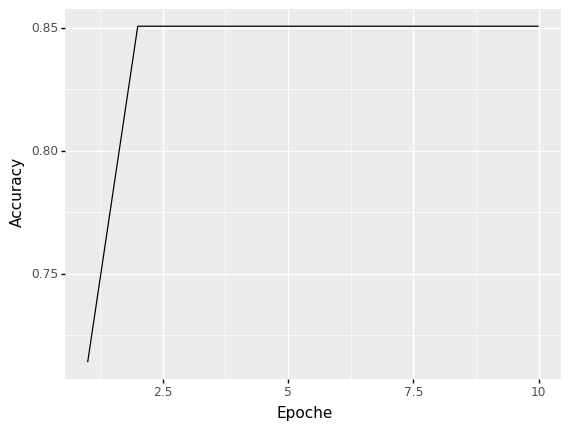

<ggplot: (138758859921)>

In [21]:
accuracies = accuracy[0:10]

frame = pd.DataFrame(accuracies, columns=['Accuracy'])
frame['Epoche'] = np.arange(1, len(accuracies)+1)
frame.head()

ggplot(frame, aes(y='Accuracy', x='Epoche')) + geom_line()